In [6]:
import numpy as np
import random
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import rc
from mpl_toolkits.axes_grid1 import make_axes_locatable
import pickle
import os
from os import listdir
from os.path import isfile, isdir, join

import re
import sys
# sys.path.insert(0, '../supermodel_test/')
from scipy.optimize import curve_fit
from scipy.interpolate import CubicSpline
from scipy.integrate import quad

rc('font', **{'family':'serif','serif':['Helvetica']})
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
rc('text', usetex=True)


%matplotlib inline

In [7]:
import numpy as np

# functions to approximate steady states and time constants
def sigmoid(x,a,b):
    return 1/(1+np.exp(-a*x+b))

def modified_sigmoid(x,a,b,c,d):
    return c/(1+np.exp(-a*x+b)) + d

def tau_fun1(x,a,b,c,d):
    y = (x - a)
    return b/(np.exp(-(c*y)) + np.exp(d*y))

def tau_fun2(x,a,b,c,d,e,f):
    y = (x - a)
    return b/(np.exp(-(c*y+d*y**2)) + np.exp(e*y+f*y**2))

def tau_fun3(x,a,b,c,d,e,f,g,h):
    y = (x - a)
    return b/(np.exp(-(c*y+d*y**2+e*y**3)) + np.exp(f*y+g*y**2+h*y**3))

def tau_fun4(x,a,b,c,d,e,f,g,h,i,j):
    y = (x - a)
    return b/(np.exp(-(c*y+d*y**2+e*y**3+f*y**4)) + np.exp(g*y+h*y**2+i*y**3+j*y**4))


In [8]:
iontypes = ["K","Na","Ca","IH"]
data_dict = {}
for ion in iontypes:
    path = "../"
    f = open(path + "/icg-channels-"+ion+".pkl","rb")
    data_dict[ion] = pickle.load(f)

## fig 1 - example curves for steady-state and tau

In [9]:
# get some nice examples of inf and tau rates from each iontype
# NOTE: assumes v array is the same for all rates

choose_rand = True
inf_examples = {}
tau_examples = {}
max_tau = 0
n_examples=3

for ion in iontypes:
    inf_examples[ion] = []
    tau_examples[ion] = []
    files = [f for f in data_dict[ion].keys() if (data_dict[ion][f]['RATES'] and data_dict[ion][f]['SM1_FIT'])]
    f_inds = np.random.permutation(len(files))
    #for i in range(n_examples): # choose 3 random examples
    c=0
    while (c < n_examples):
        f=files[np.random.randint(0,len(files))]
        g = random.choice(data_dict[ion][f]['STATES'])
        tau = data_dict[ion][f]['RATE_VALS_TAU'][g]
        if (np.array(tau).any() and data_dict[ion][f]['RATES'] and np.max(tau) < 200.0 and np.max(tau) > 10.0):
            inf_examples[ion].append(data_dict[ion][f]['RATE_VALS_SS'][g])
            tau_examples[ion].append(data_dict[ion][f]['RATE_VALS_TAU'][g])
            v = data_dict[ion][f]['RATE_VALS_V'][g]
            c += 1
max_tau = int(np.max(np.array(list(tau_examples.values())).flatten()) / 100)*100
        

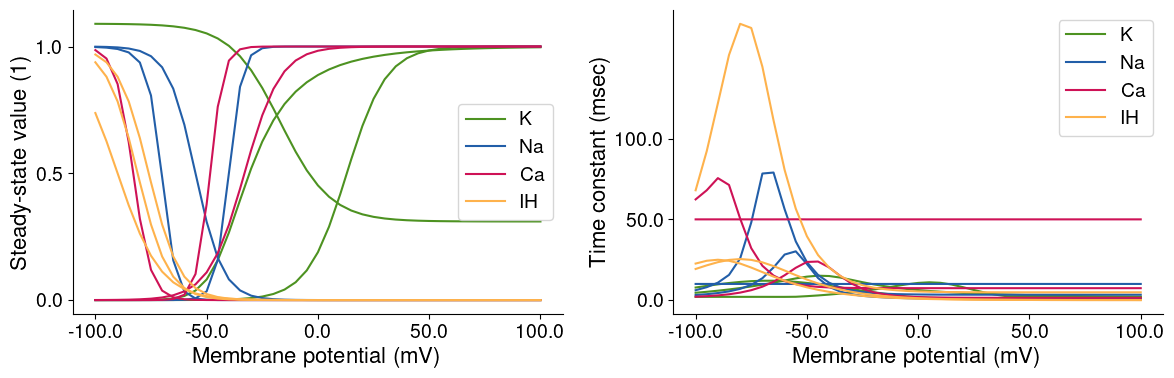

In [11]:
# graded colors for each iontype
cmap = {'K':'#4d9221', #['#005a32','#238443','#41ab5d','#78c679','#addd8e'],
        'Na':'#225ea8',  #['#4a1486','#6a51a3','#807dba','#9e9ac8','#bcbddc'],
        'Ca':'#ce1256',  #['#b10026','#e31a1c','#fc4e2a','#fd8d3c','#feb24c'],
        'IH':'#feb24c'}  #['#034e7b','#0570b0','#3690c0','#74a9cf','#a6bddb']}

msize=12
lw=2

f=plt.figure(figsize=(12,4))
matplotlib.rcParams.update({'font.size': 14})
ax=plt.subplot(1,2,1)
for i in range(len(iontypes)):
    plt.plot(v,inf_examples[iontypes[i]][0],c=cmap[iontypes[i]],label=iontypes[i])
    for j in range(1,n_examples):
        plt.plot(v,inf_examples[iontypes[i]][j],c=cmap[iontypes[i]],label=None)
plt.legend()
plt.ylabel(r'Steady-state value (1)',fontsize=16)
plt.xlabel('Membrane potential (mV)',fontsize=16)
plt.xticks(v[::10],v[::10])
plt.yticks(np.linspace(0,1,3),np.linspace(0,1,3))
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax=plt.subplot(1,2,2)
for i in range(len(iontypes)):
    plt.plot(v,tau_examples[iontypes[i]][0],c=cmap[iontypes[i]],label=iontypes[i])
    for j in range(1,n_examples):
        plt.plot(v,tau_examples[iontypes[i]][j],c=cmap[iontypes[i]],label=None)
plt.legend()
plt.ylabel(r'Time constant (msec)',fontsize=16)
plt.xlabel('Membrane potential (mV)',fontsize=16)
plt.xticks(v[::10],v[::10])
plt.yticks(np.linspace(0,max_tau,3),np.linspace(0,max_tau,3))
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.tight_layout()
f.savefig("fig1_rate_examplesA.pdf")

## Fig 2 - histogram of errors for SS and TAU fits, across all four ion types, along with some good and bad examples

In [12]:
# get all errors

SM_NUM = 2
sm_str = "SM"+str(SM_NUM)
ERR_NUM = 3
err_str = "ERROR"+str(ERR_NUM)

ss_fit_fcn = {1: sigmoid,2: modified_sigmoid,3: sigmoid,4: sigmoid,5: sigmoid}[SM_NUM]
tau_fit_fcn = {1:tau_fun3,2:tau_fun3,3:tau_fun2,4:tau_fun1,5:tau_fun4}[SM_NUM]

ss_errors = [[list(data_dict[ion][x][sm_str+'_'+err_str+'_SS'].values()) for x in data_dict[ion].keys()
             if (data_dict[ion][x]['RATES'] and data_dict[ion][x][sm_str+'_FIT'])] for ion in data_dict.keys()]
ss_errors = [item2 for sublist2 in [item for sublist in ss_errors for item in sublist] for item2 in sublist2]

tau_errors = [[list(data_dict[ion][x][sm_str+'_'+err_str+'_TAU'].values()) for x in data_dict[ion].keys()
              if (data_dict[ion][x]['RATES'] and data_dict[ion][x][sm_str+'_FIT'])] for ion in data_dict.keys()]
tau_errors = [item2 for sublist2 in [item for sublist in tau_errors for item in sublist] for item2 in sublist2]

# get params and data (for plotting)
ss_popt = [[list(data_dict[ion][x][sm_str+'_PARAMS_SS'].values()) for x in data_dict[ion].keys()
           if (data_dict[ion][x]['RATES'] and data_dict[ion][x][sm_str+'_FIT'])] for ion in data_dict.keys()]
ss_popt = [item2 for sublist2 in [item for sublist in ss_popt for item in sublist] for item2 in sublist2]
tau_popt = [[list(data_dict[ion][x][sm_str+'_PARAMS_TAU'].values()) for x in data_dict[ion].keys()
            if (data_dict[ion][x]['RATES'] and data_dict[ion][x][sm_str+'_FIT'])] for ion in data_dict.keys()]
tau_popt = [item2 for sublist2 in [item for sublist in tau_popt for item in sublist] for item2 in sublist2]
ss_data = [[list(data_dict[ion][x]['RATE_VALS_SS'].values()) for x in data_dict[ion].keys()
           if (data_dict[ion][x]['RATES'] and data_dict[ion][x][sm_str+'_FIT'])] for ion in data_dict.keys()]
ss_data = [item2 for sublist2 in [item for sublist in ss_data for item in sublist] for item2 in sublist2]
tau_data = [[list(data_dict[ion][x]['RATE_VALS_TAU'].values()) for x in data_dict[ion].keys()
            if (data_dict[ion][x]['RATES'] and data_dict[ion][x][sm_str+'_FIT'])] for ion in data_dict.keys()]
tau_data = [item2 for sublist2 in [item for sublist in tau_data for item in sublist] for item2 in sublist2]
V_data = [[list(data_dict[ion][x]['RATE_VALS_V'].values()) for x in data_dict[ion].keys()
          if (data_dict[ion][x]['RATES'] and data_dict[ion][x][sm_str+'_FIT'])] for ion in data_dict.keys()]
V_data = [item2 for sublist2 in [item for sublist in V_data for item in sublist] for item2 in sublist2]

# remove inf and nan error vals
# remove missing tau fits (why is this?)
#print(len(ss_errors), len(tau_errors), len(ss_popt), len(tau_popt), len(ss_data), len(tau_data))
to_remove = []
for i in range(len(ss_errors)):
    if np.isnan(ss_errors[i]) or (ss_errors[i] > 1e20):
        to_remove.append(i)
    if np.isnan(tau_errors[i]) or (tau_errors[i] > 1e20):
        to_remove.append(i)
    if type(tau_data[i])!=np.ndarray:
        to_remove.append(i)
        
for idx in sorted(to_remove,reverse=True):  
    del ss_errors[idx]
    del tau_errors[idx]
    del ss_popt[idx]
    del tau_popt[idx]
    del ss_data[idx]
    del tau_data[idx]
    del V_data[idx]

ss_errors = np.array(ss_errors)
tau_errors = np.array(tau_errors)
ss_popt = np.array(ss_popt)
tau_popt = np.array(tau_popt)
ss_data = np.array(ss_data)
tau_data = np.array(tau_data)
V_data = np.array(V_data)
ss_inds = np.flip(ss_errors.argsort(),0)
tau_inds = np.flip(tau_errors.argsort(),0)

print('SS errors: ',np.mean(ss_errors),np.var(ss_errors))
print('TAU errors: ',np.mean(tau_errors),np.var(tau_errors))

#skipped_files = [x for x in data_dict.keys() if not data_dict[x]['RATES']]
#print('Nr skipped mod files: ', len(skipped_files))
#nofit_files = [x for x in data_dict.keys() if (data_dict[x]['RATES'] and not data_dict[x][sm_str+'_FIT'])]
#print('Nr unfitted mod files: ', len(nofit_files))

SS errors:  0.003432324580388095 4.653865907304969e-05
TAU errors:  0.033149470982046195 0.006760309736944792


/tmp/ipykernel_123293/2758080848.py:157: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


NameError: name 'pwd' is not defined

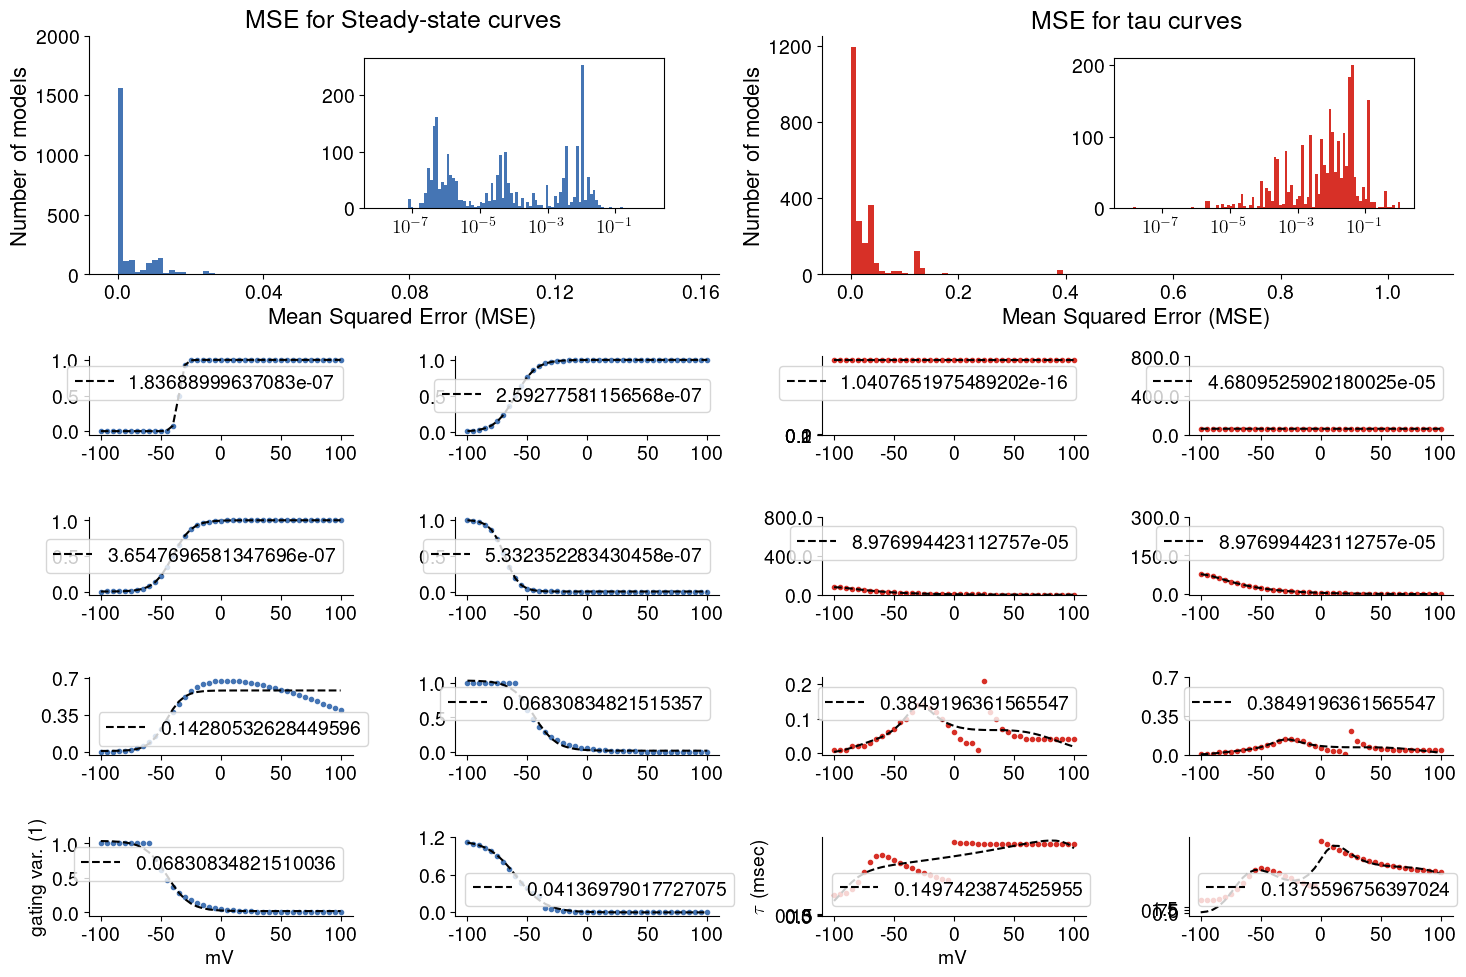

In [15]:
# FIG 2 - histogram of errors for all SS and TAU fits, along with some examples
clr1 = '#4575b4'
clr2 = '#d73027'
msize=12
lw=2

maxrange = 1.1*np.max(ss_errors)

#fig, axes = plt.subplots(2,2,figsize=(15,10))
fig = plt.figure(figsize=(15,10))
matplotlib.rcParams.update({'font.size': 14})
ax1 = plt.subplot2grid((6, 4), (0, 0), colspan=2, rowspan=2)
h = ax1.hist(ss_errors,range=(0,maxrange),bins=100,color=clr1)
plt.sca(ax1)
plt.title('MSE for Steady-state curves',fontsize=18)
plt.xlabel('Mean Squared Error (MSE)',fontsize=16)
plt.ylabel('Number of models',fontsize=16)
plt.xticks(np.linspace(0,0.16,5),np.linspace(0,0.16,5))
plt.yticks(np.arange(0,2001,500),np.arange(0,2001,500))
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)

# INF - plot the good and bad fits

(r,c) = (2,0)
n_inds = [22,50,150,390]
n=0
for i in range(2):
    for j in range(2):
        ax=plt.subplot2grid((6, 4), (r,c))
        ind = ss_inds[-n_inds[n]]
        popt = ss_popt[ind,:]
        data = ss_data[ind,:]
        V = V_data[ind,:]
        plt.plot(V,data, '.',label=None,c=clr1)
        plt.plot(V, ss_fit_fcn(V, *popt), 'k--',label=ss_errors[ind])
        #plt.title('MSE = %f' % ss_errors[ind],fontsize=14)
        plt.legend()
        plt.xticks(np.arange(-100,101,50),np.arange(-100,101,50))
        plt.yticks(np.linspace(0,1,3),np.linspace(0,1,3))
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        n += 1
        c += 1
    r += 1
    c = 0

(r,c) = (4,0)
n = 0
for i in range(2):
    for j in range(2):
        ax=plt.subplot2grid((6, 4), (r,c))
        ind = ss_inds[n]
        popt = ss_popt[ind,:]
        data = ss_data[ind,:]
        V = V_data[ind,:]
        plt.plot(V,data, '.',label=None,c=clr1)
        plt.plot(V, ss_fit_fcn(V, *popt), 'k--',label=ss_errors[ind])
        #plt.title('MSE = %f' % ss_errors[ind],fontsize=14)
        plt.legend()
        if r==5 and c==0:
            plt.xlabel('mV',fontsize=14)
            plt.ylabel('gating var. (1)',fontsize=14)
        plt.xticks(np.arange(-100,101,50),np.arange(-100,101,50))
        plt.yticks(np.linspace(0,int(np.max(data)*10+1)/10,3),np.linspace(0,int(np.max(data)*10+1)/10,3))
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        n += 1
        c += 1
    r += 1
    c = 0

# TAU

maxrange = 1.1*np.max(tau_errors)

ax2 = plt.subplot2grid((6, 4), (0, 2), colspan=2, rowspan=2)
h = ax2.hist(tau_errors,range=(0,maxrange),bins=100,color=clr2)
plt.sca(ax2)
plt.title('MSE for tau curves',fontsize=18)
plt.xlabel('Mean Squared Error (MSE)',fontsize=16)
plt.ylabel('Number of models',fontsize=16)
plt.xticks(np.around(np.linspace(0,1.0,6),decimals=1),np.around(np.linspace(0,1.0,6),decimals=1))
plt.yticks(np.arange(0,1201,400),np.arange(0,1201,400))
ax2.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)

# TAU plot the good and bad fits

(r,c) = (2,2)
n_inds = [5,121,158,163]
maxtick = [0.2,800,800,300]
n = 0
for i in range(2):
    for j in range(2):
        ax=plt.subplot2grid((6, 4), (r,c))
        ind = tau_inds[-n_inds[n]]
        popt = tau_popt[ind,:]
        data = tau_data[ind,:]
        V = V_data[ind,:]
        plt.plot(V,data, '.',label=None,c=clr2)
        plt.plot(V, tau_fit_fcn(V, *popt), 'k--',label=tau_errors[ind])
        #plt.title('MSE = %f' % tau_errors[ind],fontsize=14)
        plt.legend()
        plt.xticks(np.arange(-100,101,50),np.arange(-100,101,50))
        plt.yticks(np.linspace(0,maxtick[n],3),np.linspace(0,maxtick[n],3))
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        n += 1
        c += 1
    r += 1
    c = 2

(r,c) = (4,2)
n_inds = [17,19,50,56]
maxtick = [0.2,0.7,0.3,1.5]
n = 0
for i in range(2):
    for j in range(2):
        ax=plt.subplot2grid((6, 4), (r,c))
        ind = tau_inds[n_inds[n]]
        popt = tau_popt[ind,:]
        data = tau_data[ind,:]
        V = V_data[ind,:]
        plt.plot(V,data, '.',label=None,c=clr2)
        plt.plot(V, tau_fit_fcn(V, *popt), 'k--',label=tau_errors[ind])
        #plt.title('MSE = %f' % tau_errors[ind],fontsize=14)
        plt.legend()
        plt.xticks(np.arange(-100,101,50),np.arange(-100,101,50))
        plt.yticks(np.linspace(0,maxtick[n],3),np.linspace(0,maxtick[n],3))
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        if r==5 and c==2:
            plt.xlabel('mV',fontsize=14)
            plt.ylabel(r'$\tau$ (msec)',fontsize=14)
        n += 1
        c += 1
    r += 1
    c = 2

# Insets

left, bottom, width, height = [0.25, 0.78, 0.2, 0.15]
ax1in = fig.add_axes([left, bottom, width, height])
h = ax1in.hist(ss_errors,bins=np.logspace(-8,np.log10(maxrange),100),color=clr1)
ax1in.set_xscale("log")
#plt.xticks([10e-9,10e-7,10e-5,10e-3,10e-1],[r'$10^{-9}$',r'$10^{-7}$',r'$10^{-5}$',r'$10^{-3}$',r'$10^{-1}$'])
plt.yticks(np.arange(0,201,100),np.arange(0,201,100))

left, bottom, width, height = [0.75, 0.78, 0.2, 0.15]
ax2in = fig.add_axes([left, bottom, width, height])
h = ax2in.hist(tau_errors,bins=np.logspace(-8,np.log10(maxrange),100),color=clr2)
ax2in.set_xscale("log")
#plt.xticks([10e-9,10e-7,10e-5,10e-3,10e-1],[r'$10^{-9}$',r'$10^{-7}$',r'$10^{-5}$',r'$10^{-3}$',r'$10^{-1}$'])
plt.yticks(np.arange(0,201,100),np.arange(0,201,100))

plt.tight_layout()
fig.savefig("fig2_manual_fit.pdf", bbox_inches='tight')

/tmp/ipykernel_123293/1159479455.py:177: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


/home/chchinta/ICG_scripts/supermodel_manual_fit


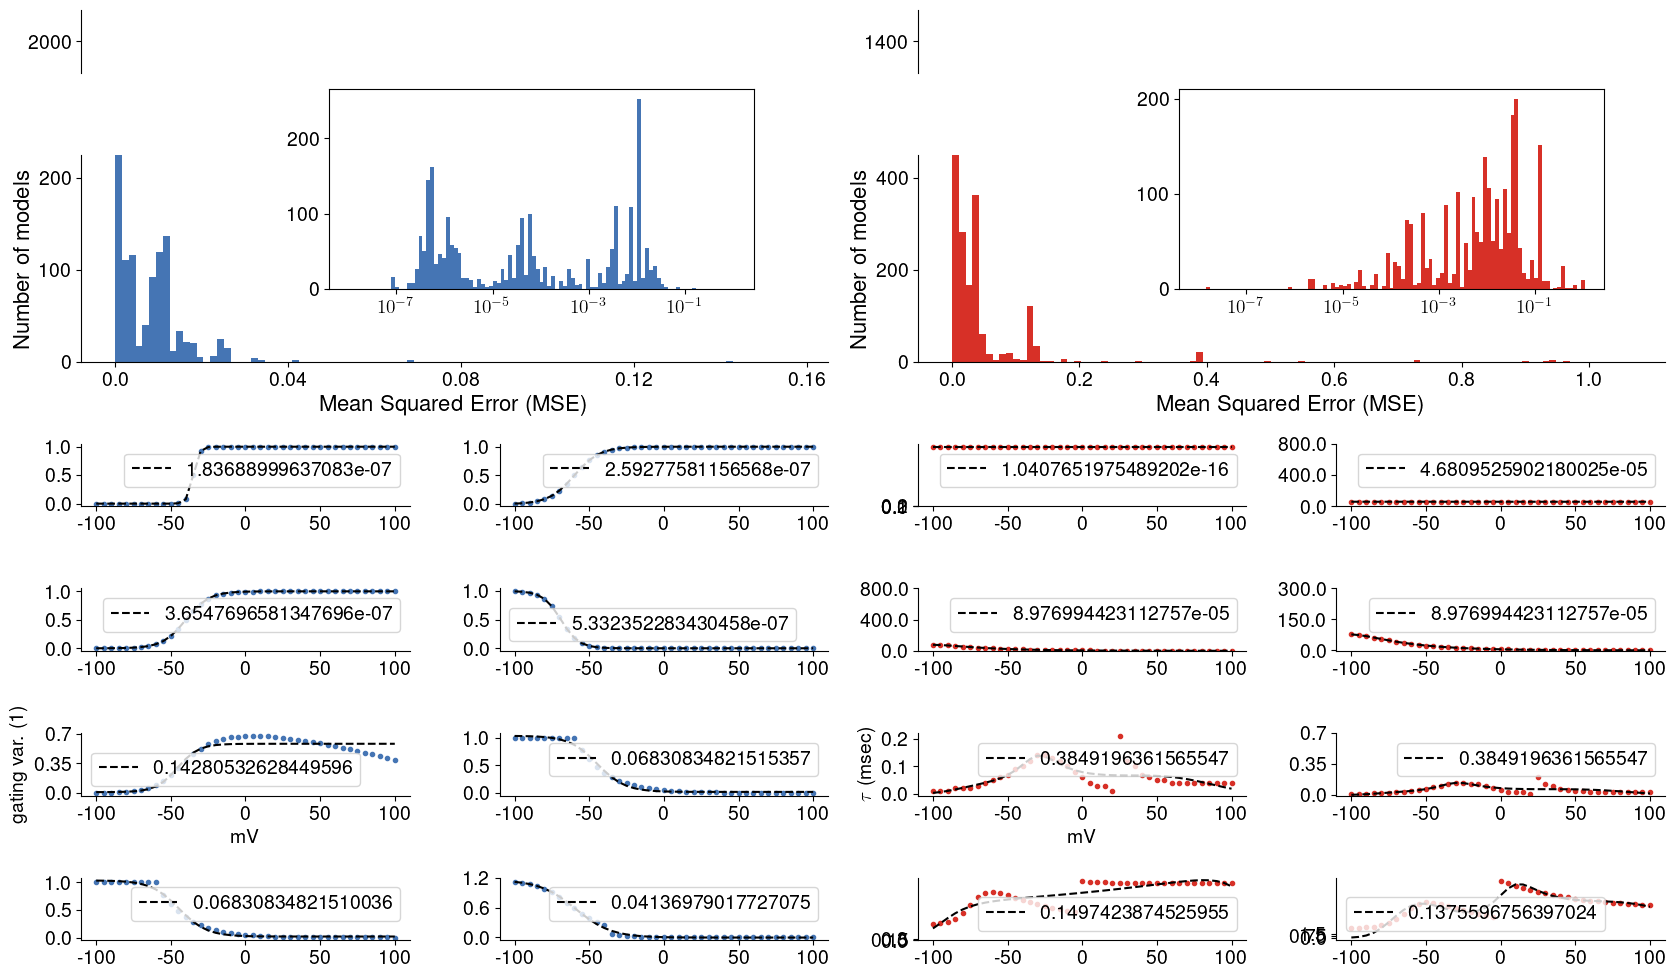

In [18]:
# FIG 2 - histogram of errors for all SS and TAU fits, along with some examples
clr1 = '#4575b4'
clr2 = '#d73027'
msize=12
lw=2

maxrange = 1.1*np.max(ss_errors)

#fig, axes = plt.subplots(2,2,figsize=(15,10))
fig = plt.figure(figsize=(17,10))
matplotlib.rcParams.update({'font.size': 14})
ax1_0 = plt.subplot2grid((7, 4), (0, 0), colspan=2, rowspan=1)
h = ax1_0.hist(ss_errors,range=(0,maxrange),bins=100,color=clr1)
plt.sca(ax1_0)
ax1_0.set_ylim([1900,2100])
ax1_0.spines['right'].set_visible(False)
ax1_0.spines['top'].set_visible(False)
ax1_0.spines['bottom'].set_visible(False)
plt.xticks([],[])
plt.yticks(np.arange(2000,2100,100),np.arange(2000,2100,100))
ax1_1 = plt.subplot2grid((7, 4), (1, 0), colspan=2, rowspan=2)#,sharex=ax1_0)
h = ax1_1.hist(ss_errors,range=(0,maxrange),bins=100,color=clr1)
plt.sca(ax1_1)
#plt.title('MSE for Steady-state curves',fontsize=18)
plt.xlabel('Mean Squared Error (MSE)',fontsize=16)
plt.ylabel('Number of models',fontsize=16)
plt.xticks(np.linspace(0,0.16,5),np.linspace(0,0.16,5))
plt.yticks(np.arange(0,201,100),np.arange(0,201,100))
ax1_1.set_ylim([0,225])
ax1_1.spines['right'].set_visible(False)
ax1_1.spines['top'].set_visible(False)

# INF - plot the good and bad fits

(r,c) = (3,0)
n_inds = [22,50,150,390]
n=0
for i in range(2):
    for j in range(2):
        ax=plt.subplot2grid((7, 4), (r,c))
        ind = ss_inds[-n_inds[n]]
        popt = ss_popt[ind,:]
        data = ss_data[ind,:]
        V = V_data[ind,:]
        plt.plot(V,data, '.',label=None,c=clr1)
        plt.plot(V, ss_fit_fcn(V, *popt), 'k--',label=ss_errors[ind])
        #plt.title('MSE = %f' % ss_errors[ind],fontsize=14)
        plt.legend()
        plt.xticks(np.arange(-100,101,50),np.arange(-100,101,50))
        plt.yticks(np.linspace(0,1,3),np.linspace(0,1,3))
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        n += 1
        c += 1
    r += 1
    c = 0

(r,c) = (5,0)
n = 0
for i in range(2):
    for j in range(2):
        ax=plt.subplot2grid((7, 4), (r,c))
        ind = ss_inds[n]
        popt = ss_popt[ind,:]
        data = ss_data[ind,:]
        V = V_data[ind,:]
        plt.plot(V,data, '.',label=None,c=clr1)
        plt.plot(V, ss_fit_fcn(V, *popt), 'k--',label=ss_errors[ind])
        #plt.title('MSE = %f' % ss_errors[ind],fontsize=14)
        plt.legend()
        if r==5 and c==0:
            plt.xlabel('mV',fontsize=14)
            plt.ylabel('gating var. (1)',fontsize=14)
        plt.xticks(np.arange(-100,101,50),np.arange(-100,101,50))
        plt.yticks(np.linspace(0,int(np.max(data)*10+1)/10,3),np.linspace(0,int(np.max(data)*10+1)/10,3))
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        n += 1
        c += 1
    r += 1
    c = 0

# TAU

maxrange = 1.1*np.max(tau_errors)

ax2_0 = plt.subplot2grid((7, 4), (0, 2), colspan=2, rowspan=1)
h = ax2_0.hist(tau_errors,range=(0,maxrange),bins=100,color=clr2)
plt.sca(ax2_0)
ax2_0.spines['right'].set_visible(False)
ax2_0.spines['top'].set_visible(False)
ax2_0.spines['bottom'].set_visible(False)
ax2_0.set_ylim([1300,1500])
plt.xticks([],[])
plt.yticks(np.arange(1400,1500,100),np.arange(1400,1500,100))
ax2_1 = plt.subplot2grid((7, 4), (1, 2), colspan=2, rowspan=2)#,sharex=ax2_0)
h = ax2_1.hist(tau_errors,range=(0,maxrange),bins=100,color=clr2)
plt.sca(ax2_1)
#plt.title('MSE for tau curves',fontsize=18)
plt.xlabel('Mean Squared Error (MSE)',fontsize=16)
plt.ylabel('Number of models',fontsize=16)
plt.xticks(np.around(np.linspace(0,1.0,6),decimals=1),np.around(np.linspace(0,1.0,6),decimals=1))
plt.yticks(np.arange(0,401,200),np.arange(0,401,200))
ax2_1.spines['right'].set_visible(False)
ax2_1.spines['top'].set_visible(False)
ax2_1.set_ylim([0,450])

# TAU plot the good and bad fits

(r,c) = (3,2)
n_inds = [5,121,158,163]
maxtick = [0.2,800,800,300]
n = 0
for i in range(2):
    for j in range(2):
        ax=plt.subplot2grid((7, 4), (r,c))
        ind = tau_inds[-n_inds[n]]
        popt = tau_popt[ind,:]
        data = tau_data[ind,:]
        V = V_data[ind,:]
        plt.plot(V,data, '.',label=None,c=clr2)
        plt.plot(V, tau_fit_fcn(V, *popt), 'k--',label=tau_errors[ind])
        #plt.title('MSE = %f' % tau_errors[ind],fontsize=14)
        plt.legend()
        plt.xticks(np.arange(-100,101,50),np.arange(-100,101,50))
        plt.yticks(np.linspace(0,maxtick[n],3),np.linspace(0,maxtick[n],3))
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        n += 1
        c += 1
    r += 1
    c = 2

(r,c) = (5,2)
n_inds = [17,19,50,56]
maxtick = [0.2,0.7,0.3,1.5]
n = 0
for i in range(2):
    for j in range(2):
        ax=plt.subplot2grid((7, 4), (r,c))
        ind = tau_inds[n_inds[n]]
        popt = tau_popt[ind,:]
        data = tau_data[ind,:]
        V = V_data[ind,:]
        plt.plot(V,data, '.',label=None,c=clr2)
        plt.plot(V, tau_fit_fcn(V, *popt), 'k--',label=tau_errors[ind])
        #plt.title('MSE = %f' % tau_errors[ind],fontsize=14)
        plt.legend()
        plt.xticks(np.arange(-100,101,50),np.arange(-100,101,50))
        plt.yticks(np.linspace(0,maxtick[n],3),np.linspace(0,maxtick[n],3))
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        if r==5 and c==2:
            plt.xlabel('mV',fontsize=14)
            plt.ylabel(r'$\tau$ (msec)',fontsize=14)
        n += 1
        c += 1
    r += 1
    c = 2

# Insets

left, bottom, width, height = [0.2, 0.7, 0.25, 0.2]
ax1in = fig.add_axes([left, bottom, width, height])
h = ax1in.hist(ss_errors,bins=np.logspace(-8,np.log10(maxrange),100),color=clr1)
ax1in.set_xscale("log")
#plt.xticks([10e-9,10e-7,10e-5,10e-3,10e-1],[r'$10^{-9}$',r'$10^{-7}$',r'$10^{-5}$',r'$10^{-3}$',r'$10^{-1}$'])
plt.yticks(np.arange(0,201,100),np.arange(0,201,100))

left, bottom, width, height = [0.7, 0.7, 0.25, 0.2]
ax2in = fig.add_axes([left, bottom, width, height])
h = ax2in.hist(tau_errors,bins=np.logspace(-8,np.log10(maxrange),100),color=clr2)
ax2in.set_xscale("log")
#plt.xticks([10e-9,10e-7,10e-5,10e-3,10e-1],[r'$10^{-9}$',r'$10^{-7}$',r'$10^{-5}$',r'$10^{-3}$',r'$10^{-1}$'])
plt.yticks(np.arange(0,201,100),np.arange(0,201,100))

plt.tight_layout()
fig.savefig("fig2_manual_fit_cut.pdf", bbox_inches='tight')
import os
print(os.getcwd())

## Fig 3 - comparison of different supermodel formulations for each ion type

/opt/anaconda/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/opt/anaconda/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


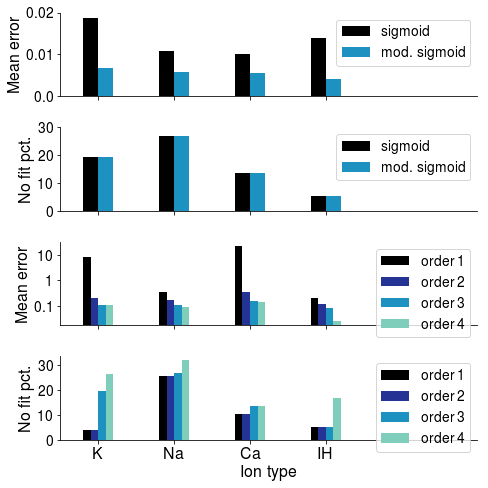

In [8]:
# plot a comparison of different ion types for the different supermodel types as well
# *** also plot how many files were not fit for each
# maybe bar plots would be better???

cmap1 = ['#542788','#4575b4']
cmap2 = ['#000000','#253494','#1d91c0','#7fcdbb']

ss_mean_err = np.zeros((2,len(iontypes)))
ss_stdev_err = np.zeros((2,len(iontypes)))
ss_no_fit_pct = np.zeros((2,len(iontypes)))
tau_mean_err = np.zeros((5,len(iontypes)))
tau_stdev_err = np.zeros((5,len(iontypes)))
tau_no_fit_pct = np.zeros((5,len(iontypes)))

for i in range(len(iontypes)):
    ion = iontypes[i]
    n_files = len([1 for x in data_dict[ion].keys() if data_dict[ion][x]['RATES']])
    for j in range(2):
        sm_str = "SM"+str(j+1)
        err_str = "ERROR"+str(1)
        ss_errors = [list(data_dict[ion][x][sm_str+'_'+err_str+'_SS'].values()) for x in data_dict[ion].keys()
                     if (data_dict[ion][x]['RATES'] and data_dict[ion][x][sm_str+'_FIT'])]
        ss_errors = np.array([item for sublist in ss_errors for item in sublist])
        ss_mean_err[j,i] = np.mean(ss_errors)
        ss_stdev_err[j,i] = np.std(ss_errors)
        no_fit = len([1 for x in data_dict[ion].keys() if (data_dict[ion][x]['RATES'] and not data_dict[ion][x][sm_str+'_FIT'])])
        ss_no_fit_pct[j,i] = 100.0*no_fit/n_files
        
    for j in range(5):
        sm_str = "SM"+str(j+1)
        err_str = "ERROR"+str(1)
        tau_errors = [list(data_dict[ion][x][sm_str+'_'+err_str+'_TAU'].values()) for x in data_dict[ion].keys()
                      if (data_dict[ion][x]['RATES'] and data_dict[ion][x][sm_str+'_FIT'])]
        tau_errors = np.array([item for sublist in tau_errors for item in sublist])
        tau_errors = tau_errors[tau_errors<1e20]
        tau_mean_err[j,i] = np.mean(tau_errors)
        tau_stdev_err[j,i] = np.std(tau_errors)
        no_fit = len([1 for x in data_dict[ion].keys() if (data_dict[ion][x]['RATES'] and not data_dict[ion][x][sm_str+'_FIT'])])
        tau_no_fit_pct[j,i] = 100.0*no_fit/n_files
        
bar_width = 0.2        

fig=plt.figure(figsize=(7,7))
ax=plt.subplot(4,1,1)
plt.bar(np.arange(4)-bar_width/2,ss_mean_err[0,:],bar_width,color=cmap2[0],label='sigmoid')#,yerr=ss_stdev_err[0,:])
plt.bar(np.arange(4)+bar_width/2,ss_mean_err[1,:],bar_width,color=cmap2[2],label='mod. sigmoid')#,yerr=ss_stdev_err[1,:])
plt.legend()
plt.ylabel(r'Mean error',fontsize=16)
#plt.xlabel('Membrane potential (mV)',fontsize=16)
plt.xticks([0,1,2,3],[])
plt.yticks(np.linspace(0,0.02,3),np.linspace(0,0.02,3))
ax.set_xlim([-0.5,5])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax=plt.subplot(4,1,2)
plt.bar(np.arange(4)-bar_width/2,ss_no_fit_pct[0,:],bar_width,color=cmap2[0],label='sigmoid')
plt.bar(np.arange(4)+bar_width/2,ss_no_fit_pct[1,:],bar_width,color=cmap2[2],label='mod. sigmoid')
plt.legend()
plt.ylabel(r'No fit pct.',fontsize=16)
plt.xticks([0,1,2,3],[])
plt.yticks(np.arange(0,31,10),np.arange(0,31,10))
ax.set_xlim([-0.5,5])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

bar_width = 0.1

ax=plt.subplot(4,1,3)
plt.bar(np.arange(4)-1.5*bar_width,tau_mean_err[3,:],bar_width,color=cmap2[0],label='order 1')#,yerr=tau_stdev_err[3,:])
plt.bar(np.arange(4)-bar_width/2,tau_mean_err[2,:],bar_width,color=cmap2[1],label='order 2')#,yerr=tau_stdev_err[2,:])
plt.bar(np.arange(4)+bar_width/2,tau_mean_err[1,:],bar_width,color=cmap2[2],label='order 3')#,yerr=tau_stdev_err[1,:])
plt.bar(np.arange(4)+1.5*bar_width,tau_mean_err[4,:],bar_width,color=cmap2[3],label='order 4')#,yerr=tau_stdev_err[4,:])
ax.set_yscale("log")
plt.legend()
plt.ylabel(r'Mean error',fontsize=16)
#plt.xlabel('Membrane potential (mV)',fontsize=16)
plt.xticks([0,1,2,3],[])
plt.yticks([10**-1,10**0,10**1],[10**-1,10**0,10**1])
ax.set_xlim([-0.5,5])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax=plt.subplot(4,1,4)
plt.bar(np.arange(4)-1.5*bar_width,tau_no_fit_pct[3,:],bar_width,color=cmap2[0],label='order 1')
plt.bar(np.arange(4)-bar_width/2,tau_no_fit_pct[2,:],bar_width,color=cmap2[1],label='order 2')
plt.bar(np.arange(4)+bar_width/2,tau_no_fit_pct[1,:],bar_width,color=cmap2[2],label='order 3')
plt.bar(np.arange(4)+1.5*bar_width,tau_no_fit_pct[4,:],bar_width,color=cmap2[3],label='order 4')
plt.legend()
plt.ylabel(r'No fit pct.',fontsize=16)
plt.xlabel('Ion type',fontsize=16)
plt.xticks([0,1,2,3],['K','Na','Ca','IH'],fontsize=16)
plt.yticks(np.arange(0,31,10),np.arange(0,31,10))
ax.set_xlim([-0.5,5])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.tight_layout()
fig.savefig("fig3_manfit_compare.pdf", bbox_inches='tight')


## Inspecting individual examples

/opt/anaconda/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/opt/anaconda/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


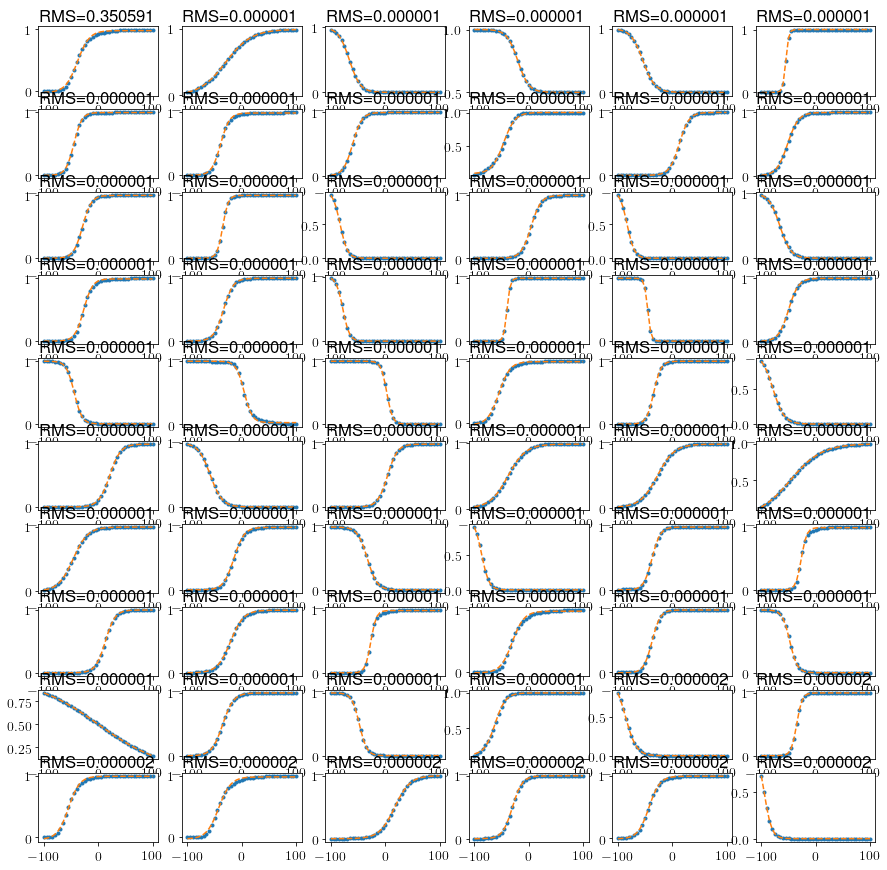

In [9]:
# plot some individual examples - arranged from worst to best

ss_inds = np.flip(np.array(ss_errors).argsort(),0)
plt.figure(figsize=(15,15))
c=1
for i in range(0,60):
    ind = ss_inds[-i]
    popt = ss_popt[ind]
    data = ss_data[ind]
    V = V_data[ind]
    plt.subplot(10,6,c)
    plt.plot(V, data, '.')
    plt.plot(V, ss_fit_fcn(V, *popt), '--')
    plt.title('RMS=%f' % ss_errors[ind])
    c += 1


## plotting: time constant curves

IndexError: index -179 is out of bounds for axis 0 with size 178

/opt/anaconda/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/opt/anaconda/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/opt/anaconda/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/opt/anaconda/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/opt/anaconda/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning

/opt/anaconda/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/opt/anaconda/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


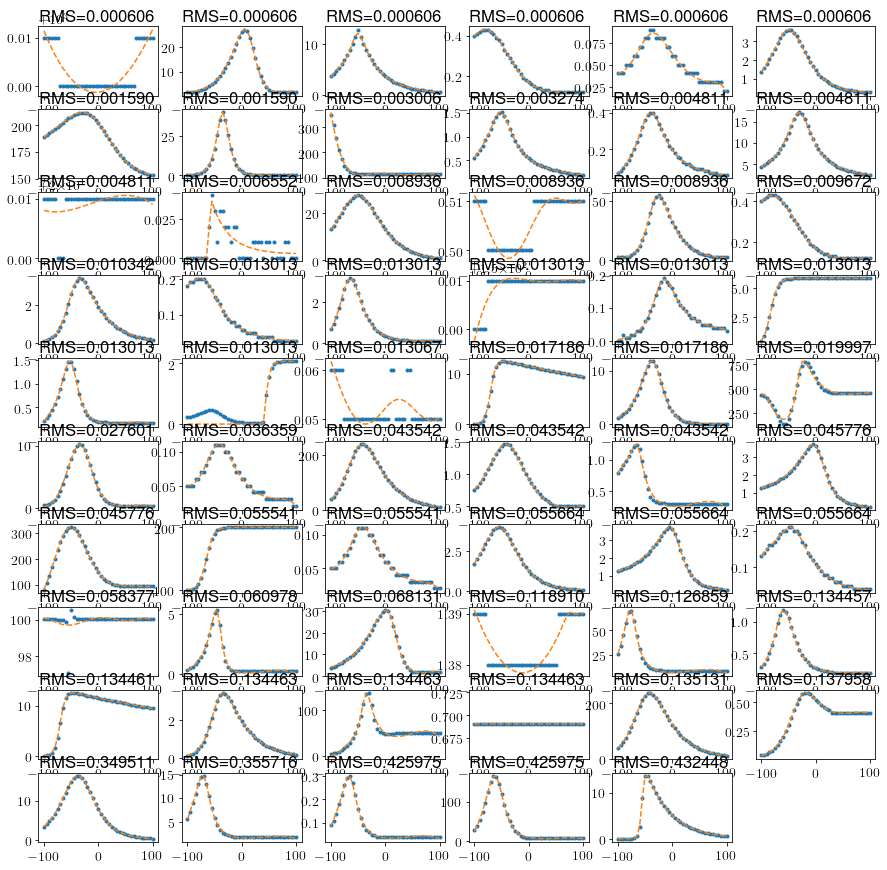

In [10]:
# plot some individual examples - arranged from worst to best

tau_inds = np.flip(np.array(tau_errors).argsort(),0)
plt.figure(figsize=(15,15))
c=1
for i in range(120,180):
    ind = tau_inds[-i]
    popt = tau_popt[ind]
    data = tau_data[ind]
    plt.subplot(10,6,c)
    plt.plot(V, data, '.')
    plt.plot(V, tau_fit_fcn(V, *popt), '--')
    plt.title('RMS=%f' % tau_errors[ind])
    c += 1


kdr 0.0012043347525858173
ka 0.0653648263093828
km 0.01941068361255929
k2 0.013340428819469332
naf 0.023175384279360015
nap 0.004004827239462424
cat 0.10715928380745014
cal 0.03160827288320722
ar 0.13268662068125175
[ 9.99775166e-02 -2.94968332e+00  9.99435504e-01 -2.09640612e-06]
[ 1.17642626e-01 -7.05855613e+00  9.99997844e-01 -8.35363641e-07]
[-1.66651884e-01  1.29988790e+01  9.99993162e-01 -2.12982536e-07]
[ 1.99750068e-01 -5.29810543e+00  9.89867200e-01 -3.90580783e-03]
[ 0.0639704  -0.73343626  0.95423308  0.0071043 ]
[-9.43473286e-02  5.47212830e+00  9.99885909e-01  4.15111660e-05]
[ 1.00083459e-01 -3.45370294e+00  9.99633825e-01  5.92619936e-05]
[-9.34667318e-02  5.87908527e+00  9.99950778e-01  2.79158154e-05]
[ 1.00248871e-01 -4.81951853e+00  9.99868901e-01  2.51874861e-05]
[ 0.13110995 -2.57730487  0.99485151  0.00816927]
[ 1.61275757e-01 -9.03146990e+00  1.00000284e+00 -2.51604232e-06]
[-2.49952700e-01  1.99962853e+01  9.99933327e-01 -3.30847386e-07]
[-1.80738924e-01  1.3567

/opt/anaconda/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/opt/anaconda/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


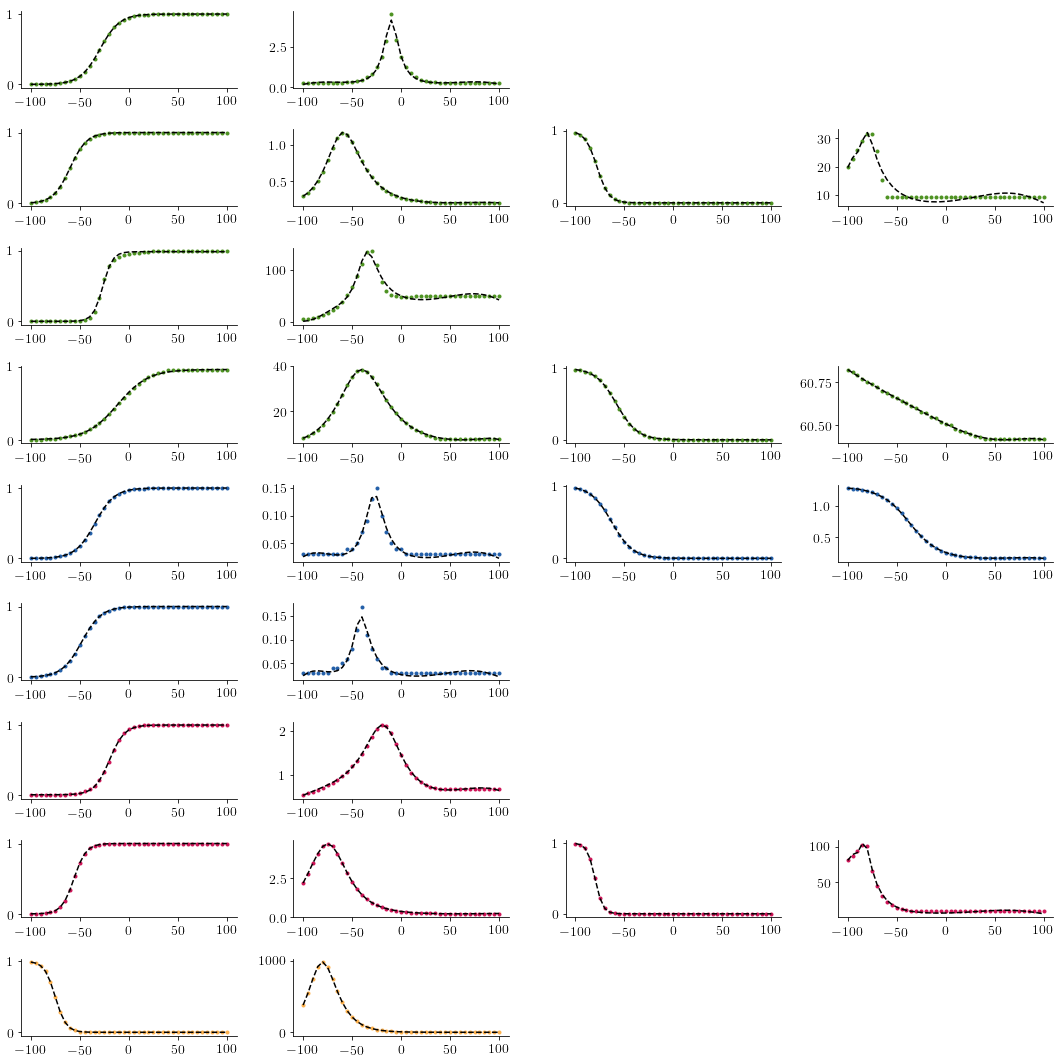

In [13]:
# TRAUB FITS

SM_NUM = 2
sm_str = 'SM'+str(SM_NUM)
ss_fit_fcn = modified_sigmoid
tau_fit_fcn = tau_fun3

#cmap = ['#005a32','#005a32','#005a32','#005a32','#4a1486','#4a1486','#b10026','#b10026']
cmap = ['#4d9221','#4d9221','#4d9221','#4d9221','#225ea8','#225ea8','#ce1256','#ce1256','#feb24c']

# kdr, ka, km, k2,
# naf, nap
# cal, cat
print('kdr',data_dict['K']['20756_kdr.mod']['ICG_SM2_ERROR1']['total'])
print('ka',data_dict['K']['20756_ka.mod']['ICG_SM2_ERROR1']['total'])
print('km',data_dict['K']['20756_km.mod']['ICG_SM2_ERROR1']['total'])
print('k2',data_dict['K']['20756_k2.mod']['ICG_SM2_ERROR1']['total'])
print('naf',data_dict['Na']['20756_naf.mod']['ICG_SM2_ERROR1']['total'])
print('nap',data_dict['Na']['20756_nap.mod']['ICG_SM2_ERROR1']['total'])
print('cat',data_dict['Ca']['20756_cat.mod']['ICG_SM2_ERROR1']['total'])
print('cal',data_dict['Ca']['20756_cal.mod']['ICG_SM2_ERROR1']['total'])
print('ar',data_dict['IH']['20756_ar.mod']['ICG_SM2_ERROR1']['total'])

to_plot = ['20756_kdr.mod','20756_ka.mod','20756_km.mod','20756_k2.mod',
          '20756_naf.mod','20756_nap.mod','20756_cal.mod','20756_cat.mod','20756_ar.mod']
ion_to_plot = ['K','K','K','K','Na','Na','Ca','Ca','IH']

f=plt.figure(figsize=(15,15))

for i in range(len(to_plot)):

    gates = data_dict[ion_to_plot[i]][to_plot[i]]['STATES']
    for j in range(len(gates)):
        ax=plt.subplot(9,4,4*i+2*j+1)
        rates = data_dict[ion_to_plot[i]][to_plot[i]]['RATE_VALS_SS'][gates[j]]
        v = data_dict[ion_to_plot[i]][to_plot[i]]['RATE_VALS_V'][gates[j]]
        plt.plot(v,rates,'.',c=cmap[i])
        popt = data_dict[ion_to_plot[i]][to_plot[i]][sm_str+'_PARAMS_SS'][gates[j]]
        print(popt)
        plt.plot(v, ss_fit_fcn(v, *popt), 'k--')
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        ax=plt.subplot(9,4,4*i+2*j+2)
        rates = data_dict[ion_to_plot[i]][to_plot[i]]['RATE_VALS_TAU'][gates[j]]
        v = data_dict[ion_to_plot[i]][to_plot[i]]['RATE_VALS_V'][gates[j]]
        plt.plot(v,rates,'.',c=cmap[i])
        popt = data_dict[ion_to_plot[i]][to_plot[i]][sm_str+'_PARAMS_TAU'][gates[j]]
        plt.plot(v, tau_fit_fcn(v, *popt), 'k--')
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)

plt.tight_layout()
f.savefig("traub_fits.pdf")
